In [120]:
import os
import json
import xml.etree.ElementTree as ET
from datetime import datetime

import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import pystac
import sys
from shapely.geometry import mapping, box
sys.path.append('/home/vishnu/corestack_STAC')
from constants import DEFAULT_START_DATE, DEFAULT_END_DATE


In [121]:


base_dir = "/home/vishnu/corestack_STAC/STAC_common/data"
corestack_dir = os.path.join(base_dir, "Corestack Catalogs")
gobindpur_dir = os.path.join(corestack_dir, "gobindpur")
raster_dir = os.path.join(gobindpur_dir, "raster")
vector_dir = os.path.join(gobindpur_dir, "vector")

os.makedirs(raster_dir, exist_ok=True)
os.makedirs(vector_dir, exist_ok=True)

http_base = "https://raw.githubusercontent.com/vishnus4059/STAC_common/main/data/Corestack%20Catalogs/gobindpur"

raster_filename = "saraikela-kharsawan_gobindpur_2023-07-01_2024-06-30_LULCmap_10m.tif"
vector_filename = "swb2_saraikela-kharsawan_gobindpur.geojson"
raster_path = os.path.join(base_dir, raster_filename)
vector_path = os.path.join(base_dir, vector_filename)

raster_thumb = os.path.join(raster_dir, "thumbnail.png")
vector_thumb = os.path.join(vector_dir, "thumbnail.png")

raster_style_file = os.path.join(base_dir, "style_file.qml")
vector_style_file = os.path.join(base_dir, "swb_style.qml")


In [122]:
def extract_raster_dates_from_filename(filename):
    try:
        parts = filename.split('_')
        start_date = datetime.strptime(parts[2], "%Y-%m-%d")
        end_date = datetime.strptime(parts[3], "%Y-%m-%d")
    except Exception as e:
        print(f" Failed to extract raster dates from filename '{filename}': {e}")
        start_date = DEFAULT_START_DATE
        end_date = DEFAULT_END_DATE
    return start_date, end_date


In [123]:
def parse_qml_classes(qml_path):
    tree = ET.parse(qml_path)
    root = tree.getroot()
    classes = []

    for entry in root.findall(".//paletteEntry"):
        class_info = {}
        for attr_key, attr_value in entry.attrib.items():
            if attr_key == "value":
                try:
                    class_info[attr_key] = int(attr_value)
                except ValueError:
                    class_info[attr_key] = attr_value
            else:
                class_info[attr_key] = attr_value
        classes.append(class_info)
    return classes

In [134]:
import xml.etree.ElementTree as ET

def parse_single_symbol_qml(qml_path):
    def parse_rgba_to_hex(rgba_str):
        parts = rgba_str.strip().split(',')
        if len(parts) >= 3:
            r, g, b = map(int, parts[:3])  # discard alpha
            return f"#{r:02x}{g:02x}{b:02x}"
        return "#CCCCCC"

    tree = ET.parse(qml_path)
    root = tree.getroot()

    renderer = root.find(".//renderer-v2")
    if renderer is None or renderer.attrib.get("type") != "singleSymbol":
        raise ValueError("Only singleSymbol QML styles are supported")

    symbol = renderer.find(".//symbol")
    layer = symbol.find(".//layer")

    fill_color = "#CCCCCC"
    outline_color = "#333333"

    for prop in layer.findall(".//prop"):
        key = prop.attrib.get("k")
        val = prop.attrib.get("v")
        if key == "color":
            fill_color = parse_rgba_to_hex(val)
        elif key == "outline_color":
            outline_color = parse_rgba_to_hex(val)

    return fill_color, outline_color


In [154]:
def generate_vector_thumbnail_single_style(vector_path, out_path, fill_color="#CCCCCC", outline_color="#333333"):
    import geopandas as gpd
    import matplotlib.pyplot as plt

    gdf = gpd.read_file(vector_path)

    if gdf.empty:
        raise ValueError("GeoDataFrame is empty")

    if gdf.crs is None or gdf.crs.to_epsg() != 4326:
        gdf = gdf.to_crs(epsg=4326)

    fig, ax = plt.subplots(figsize=(3, 3))
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    gdf.plot(ax=ax, color=fill_color, edgecolor=outline_color, linewidth=0.5)

    ax.set_xlim(*gdf.total_bounds[[0, 2]])
    ax.set_ylim(*gdf.total_bounds[[1, 3]])
    ax.axis("off")
    plt.savefig(out_path, dpi=150, bbox_inches="tight", pad_inches=0, facecolor=fig.get_facecolor())
    plt.close()


In [155]:
def generate_raster_thumbnail(tif_path, out_path):
    with rasterio.open(tif_path) as src:
        arr = src.read(1)
    plt.figure(figsize=(3, 3))
    plt.imshow(arr, cmap="tab20")
    plt.axis('off')
    plt.savefig(out_path, bbox_inches='tight', pad_inches=0)
    plt.close()

def generate_vector_thumbnail(vector_path, out_path):
    gdf = gpd.read_file(vector_path)
    if gdf.crs is None or gdf.crs.to_epsg() != 4326:
        gdf = gdf.to_crs(epsg=4326)
    fig, ax = plt.subplots(figsize=(3, 3))
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")
    gdf.plot(ax=ax, color="lightblue", edgecolor="blue", linewidth=0.5)
    ax.axis('off')
    plt.savefig(out_path, dpi=150, bbox_inches='tight', pad_inches=0, facecolor=fig.get_facecolor())
    plt.close()


In [157]:
def generate_legend_image(legend_data, output_path):
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches

    labels = [entry.get("label", str(entry["value"])) for entry in legend_data]
    colors = [entry["color"] for entry in legend_data]

    fig_height = max(1, len(labels) * 0.4)
    fig, ax = plt.subplots(figsize=(3, fig_height))
    ax.axis("off")

    handles = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)]
    ax.legend(handles=handles, loc="center left", frameon=False)

    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()


In [160]:
def create_raster_item():
    start_date, end_date = extract_raster_dates_from_filename(raster_filename)
    with rasterio.open(raster_path) as src:
        bounds = src.bounds
        geom = mapping(box(*bounds))
        bbox = [bounds.left, bounds.bottom, bounds.right, bounds.top]

    generate_raster_thumbnail(raster_path, raster_thumb)
    style_info = parse_qml_classes(raster_style_file)

   
    style_json_path = os.path.join(raster_dir, "legend.json")
    with open(style_json_path, "w") as f:
        json.dump(style_info, f, indent=2)

    
    legend_img_path = os.path.join(raster_dir, "legend.png")
    generate_legend_image(style_info, legend_img_path)

    
    item = pystac.Item(
        id="gobindpur_lulc_raster",
        geometry=geom,
        bbox=bbox,
        datetime=start_date,
        properties={
            "proj:epsg": 4326,
            "title": "LULC Raster - Gobindpur",
            "description": "Land Use Land Cover raster map of Gobindpur",
            "lulc:classes": style_info,
            "start_datetime": start_date.isoformat(),
            "end_datetime": end_date.isoformat()
        }
    )

    # Add raster data and assets
    item.add_asset("data", pystac.Asset(
        href=f"{http_base}/{raster_filename}",
        media_type=pystac.MediaType.GEOTIFF,
        roles=["data"],
        title="LULC Geotiff"
    ))
    item.add_asset("thumbnail", pystac.Asset(
        href=f"{http_base}/raster/thumbnail.png",
        media_type=pystac.MediaType.PNG,
        roles=["thumbnail"],
        title="Raster Thumbnail"
    ))
    item.add_asset("legend_image", pystac.Asset(
        href=f"{http_base}/raster/legend.png",
        media_type=pystac.MediaType.PNG,
        roles=["thumbnail", "metadata"],
        title="Legend Image"
    ))
    item.add_asset("legend", pystac.Asset(
        href=f"{http_base}/raster/legend.json",
        media_type=pystac.MediaType.JSON,
        roles=["metadata"],
        title="Legend JSON"
    ))


    item.set_self_href(os.path.join(raster_dir, "item.json"))
    item.save_object()
    return item


In [146]:
raster_item=create_raster_item()

Start Date: 2023-07-01T00:00:00
End Date: 2024-06-30T00:00:00


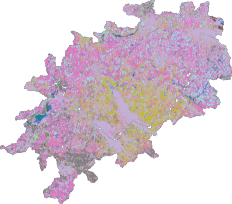

In [147]:
print("Start Date:", raster_item.properties["start_datetime"])
print("End Date:", raster_item.properties["end_datetime"])

from IPython.display import Image, display
display(Image(filename=raster_thumb))

In [115]:
print("DEBUG Start Date:", DEFAULT_START_DATE)
print("DEBUG End Date:", DEFAULT_END_DATE)

DEBUG Start Date: 2017-07-01 00:00:00
DEBUG End Date: 2024-06-30 00:00:00


In [161]:
def create_vector_item():
    start_date = DEFAULT_START_DATE
    end_date = DEFAULT_END_DATE

    gdf = gpd.read_file(vector_path)
    geom = mapping(gdf.union_all())
    bounds = gdf.total_bounds
    bbox = [float(b) for b in bounds]

    generate_vector_thumbnail(vector_path, vector_thumb)
    style_info = parse_qml_classes(vector_style_file)
    style_json_path = os.path.join(vector_dir, "style.json")
    with open(style_json_path, "w") as f:
        json.dump(style_info, f, indent=2)

    item = pystac.Item(
        id="gobindpur_swb_vector",
        geometry=geom,
        bbox=bbox,
        datetime=start_date,
        properties={
            "proj:epsg": 4326,
            "title": "SWB Vector - Gobindpur",
            "description": "Micro watershed (SWB) vector layer for Gobindpur",
            "style": style_info,
            "start_datetime": start_date.isoformat(),
            "end_datetime": end_date.isoformat()
        }
    )
    item.add_asset("data", pystac.Asset(
        href=f"{http_base}/{vector_filename}",
        media_type=pystac.MediaType.GEOJSON,
        roles=["data"],
        title="SWB GeoJSON"
    ))
    item.add_asset("thumbnail", pystac.Asset(
        href=f"{http_base}/vector/thumbnail.png",
        media_type=pystac.MediaType.PNG,
        roles=["thumbnail"],
        title="Vector Thumbnail"
    ))
    item.add_asset("style", pystac.Asset(
        href=f"{http_base}/vector/swb_style_thumbnail.json",
        media_type=pystac.MediaType.PNG,
        roles=["style"],
        title="Vector style thumbnail"
    ))
    item.set_self_href(os.path.join(vector_dir, "item.json"))
    item.save_object()
    return item


In [162]:

vector_item = create_vector_item()


Start Date: 2017-07-01T00:00:00
End Date: 2024-06-30T00:00:00


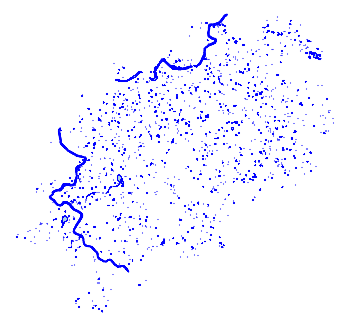

CRS: EPSG:4326
Geometry types: ['Polygon' 'MultiPolygon']
Bounds: [85.83186726 22.43829904 86.20314537 22.76133421]
Number of features: 2306


,id,MWS_UID,UID,any,area_17-18,area_18-19,area_19-20,area_20-21,area_21-22,area_22-23,...,kr_23-24,krz_17-18,krz_18-19,krz_19-20,krz_20-21,krz_21-22,krz_22-23,krz_23-24,water,geometry
0,00000000000000000043,6_2495,6_2495_67,1,0.11,0.0,0.23,0.10,0.17,0.14,...,70.833333,33.333333,0.0,87.500000,0.000000,62.500000,0.000000,12.500000,1,"POLYGON ((85.96814 22.66557, 85.96824 22.66557..."
1,00000000000000000045,6_3468,6_3468_69,1,0.06,0.0,0.24,0.05,0.12,0.21,...,96.153846,23.076923,0.0,92.307692,19.230769,0.000000,76.923077,76.923077,1,"POLYGON ((86.1187 22.61437, 86.11888 22.61437,..."
2,0000000000000000004f,6_3645,6_3645_79,1,0.26,0.0,0.31,0.05,0.24,0.27,...,59.375000,46.875000,0.0,90.625000,0.000000,75.000000,81.250000,56.250000,1,"POLYGON ((86.05905 22.68228, 86.05923 22.68228..."
3,00000000000000000051,6_2462,6_2462_81,1,0.30,0.0,0.31,0.10,0.28,0.23,...,72.727273,42.424242,0.0,93.939394,0.000000,51.515152,0.000000,72.727273,1,"POLYGON ((85.94757 22.67572, 85.94766 22.67572..."
4,00000000000000000053,6_7612,6_7612_83,1,0.01,0.0,0.33,0.14,0.00,0.28,...,0.000000,2.941176,0.0,97.058824,23.529412,0.000000,67.647059,0.000000,1,"POLYGON ((86.05151 22.54565, 86.0516 22.54565,..."


In [163]:
print("Start Date:", vector_item.properties["start_datetime"])
print("End Date:", vector_item.properties["end_datetime"])

from IPython.display import Image, display
display(Image(filename=vector_thumb))

import geopandas as gpd

gdf = gpd.read_file(vector_path)
print("CRS:", gdf.crs)
print("Geometry types:", gdf.geom_type.unique())
print("Bounds:", gdf.total_bounds)
print("Number of features:", len(gdf))
gdf.head()


In [153]:
gobindpur_catalog = pystac.Catalog(
    id="gobindpur",
    title="GobindpurCatalog",
    description="Gobindpur catalog with LULC raster and SWB vector layers"
)
gobindpur_catalog.add_item(create_raster_item())
gobindpur_catalog.add_item(create_vector_item())
gobindpur_catalog.set_self_href(os.path.join(gobindpur_dir, "catalog.json"))

corestack_catalog = pystac.Catalog(
    id="corestack",
    title="CorestackCatalogs",
    description="Root catalog containing all subcatalogs like Gobindpur"
)
corestack_catalog.add_child(gobindpur_catalog)
corestack_catalog.set_self_href(os.path.join(corestack_dir, "catalog.json"))
corestack_catalog.normalize_and_save(corestack_dir, catalog_type=pystac.CatalogType.SELF_CONTAINED)

print(f" Root STAC Catalog created at: {os.path.join(corestack_dir, 'catalog.json')}")


 Root STAC Catalog created at: /home/vishnu/corestack_STAC/STAC_common/data/Corestack Catalogs/catalog.json
